In [9]:
import numpy as np

np.random.seed(410)

In [10]:
import torch

from util.spray_util import load_spray_df

spray_directory = "res/sprays"
df = load_spray_df(spray_directory)

print("samples:", df.shape[0])
df.head()

samples: 49839


,match_id,map_id,player_id,filename,length
0,92650,0,76561198257770857,95.npy,9
1,92650,0,76561198257770857,97.npy,7
2,92650,0,76561198257770857,96.npy,9
3,92650,0,76561198257770857,98.npy,15
4,92650,0,76561198257770857,102.npy,5


In [11]:
# minimum length of sprays
min_length = 7
df = df[df["length"] >= min_length].reset_index(drop=True)

# minimum number of sprays per player
min_samples = 10

player_ids = [
    player_id
    for player_id, count in zip(*np.unique(df["player_id"], return_counts=True))
    if count >= min_samples
]
print("player ids:", len(player_ids))

player ids: 722


In [12]:
from sklearn.model_selection import train_test_split

player_ids_train, player_ids_test = train_test_split(player_ids, test_size=0.2, random_state=410)

print("train player ids:", len(player_ids_train))
print("test player ids:", len(player_ids_test))

train player ids: 577
test player ids: 145


In [13]:
import os


def load_sprays() -> list:
    ans = []
    for idx, row in df.iterrows():
        # get spray path
        filename = f"{row.match_id}/{row.map_id}/{row.player_id}/{row.filename}"
        filepath = os.path.join(spray_directory, filename)

        # load spray
        array = np.load(filepath)

        # calculate velocity (degrees/shot) and acceleration (degrees/shot^2)
        # vel = np.diff(array, axis=0)
        # acc = np.diff(vel, axis=0)
        # features = np.concatenate((array[2:, :], vel[1:, :], acc), axis=1)
        ans.append(array)
    return ans


data = load_sprays()

# normalize (z-scale) pitch and yaw
all_shots = np.concatenate(data, axis=0)
mean = all_shots.mean(axis=0)
std = all_shots.std(axis=0)

data_zscaled = []
for spray in data:
    # spray_zscaled = (spray - mean) / std
    spray_zscaled = spray / std
    data_zscaled.append(torch.from_numpy(spray_zscaled))  # also convert to torch tensor

print("spray shape:", data_zscaled[0].shape)

spray shape: torch.Size([9, 2])


In [14]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence


class SprayModel(torch.nn.Module):
    def __init__(self, hidden_size: int = 64, num_layers: int = 3, bidirectional: bool = True):
        super().__init__()
        self._num_lstm_layers = num_layers
        self._bidirectional = bidirectional
        self.lstm = torch.nn.LSTM(
            input_size=2,
            hidden_size=hidden_size,
            num_layers=self._num_lstm_layers,
            batch_first=True,
            bidirectional=self._bidirectional,
        )

    def embedding(self, x):
        _, (h, c) = self.lstm(x)
        if self._bidirectional:
            hf, cf = h[self._num_lstm_layers - 1], c[self._num_lstm_layers - 1]
            hb, cb = h[-1], c[-1]
            embedding = torch.cat([hf, cf, hb, cb], dim=-1)
        else:
            h, c = h[-1], c[-1]
            embedding = torch.cat([h, c], dim=-1)
        return embedding

    def forward(self, batch):
        packed_sprays = self._pack_sprays(batch)
        embedding = self.embedding(packed_sprays)
        return embedding

    @staticmethod
    def _pack_sprays(batch):
        lengths = torch.tensor([s.shape[0] for s in batch], dtype=torch.long)
        padded_sprays = pad_sequence(batch, batch_first=True)
        packed_sprays = pack_padded_sequence(padded_sprays, lengths, batch_first=True, enforce_sorted=False)
        return packed_sprays


model = SprayModel()

In [15]:
def sample_batch(batch_player_ids: list[str], n_players: int = 16, samples_per_player: int = 4):
    """Generate a minibatch of spray samples.

    :param batch_player_ids: the player IDs to sample from for the batch.
    :param n_players: the number of players to include in the batch.
    :param samples_per_player: the number of samples per player to include in the batch.
    :return: the batch as a tuple (sprays, labels).
    """
    batch_player_ids = np.random.choice(batch_player_ids, size=n_players, replace=False)
    labels, sprays = [], []
    for batch_player_id in batch_player_ids:
        pool = df[df["player_id"] == batch_player_id]
        data_idx = np.random.choice(pool.index, size=samples_per_player, replace=False)
        labels.extend(pool.loc[data_idx].player_id)
        sprays.extend([data_zscaled[idx] for idx in data_idx])
    labels = np.array(labels)
    return sprays, labels


def mine_triplets(embeddings, labels, margin: float = 1.0):
    triplets = []
    dist = torch.cdist(embeddings, embeddings, p=2)
    for i in range(len(embeddings)):
        anchor_label = labels[i]

        # Get positives (same player, exclude self)
        positive_mask = torch.from_numpy(labels == anchor_label) & (torch.arange(len(labels)) != i)
        positive_indices = torch.where(positive_mask)[0]

        # Get negatives (different player)
        negative_mask = torch.from_numpy(labels != anchor_label)
        negative_indices = torch.where(negative_mask)[0]

        # Select the hardest positive (closest among same-player samples)
        positive_idx = positive_indices[torch.argmin(dist[i, positive_indices])]

        # Select a semi-hard negative (hardest negative within the margin)
        neg_distances = dist[i, negative_indices]
        semi_hard_negatives = negative_indices[
            (neg_distances > dist[i, positive_idx]) & (neg_distances < dist[i, positive_idx] + margin)]

        # if we have semi-hard negatives, include in returned triplets
        if len(semi_hard_negatives) > 0:
            negative_idx = semi_hard_negatives[torch.argmin(dist[i, semi_hard_negatives])]
            triplets.append((i, positive_idx.item(), negative_idx.item()))

    anchor, positive, negative = zip(*triplets)
    anchor, positive, negative = torch.tensor(anchor), torch.tensor(positive), torch.tensor(negative)
    return anchor, positive, negative

In [16]:
from tqdm import tqdm

triplet_loss = torch.nn.TripletMarginLoss(margin=0.2, p=2, eps=1e-7)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


def train(n_batches: int = 1_000):
    model.train()

    avg_loss = 0.0

    for _ in range(n_batches):
        sprays, labels = sample_batch(player_ids_train)
        embeddings = model(sprays)
        a, p, n = mine_triplets(embeddings, labels)
        a, p, n = embeddings[a], embeddings[p], embeddings[n]

        loss = triplet_loss(a, p, n)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(avg_loss / n_batches)


n_epochs = 10
for epoch in range(1, n_epochs + 1):
    print("epoch", epoch)
    train()

epoch 1
0.05788693371601403
epoch 2
0.04479851902462542
epoch 3
0.04572523397393525
epoch 4
0.04419376595597714
epoch 5
0.04621525129675865
epoch 6
0.04488736869301647
epoch 7
0.04299566270783543
epoch 8
0.044969033846631645
epoch 9


KeyboardInterrupt: 

In [9]:
# from tqdm import tqdm
#
# # generate our initial embeddings
# model.eval()
# embeddings = []
# for spray in tqdm(data):
#     embeddings.append(model.embedding(torch.from_numpy(spray)))
# embeddings = torch.stack(embeddings)
# embeddings.shape

In [10]:
# # generate anchor-positive pairs
#
# def generate_anchor_positive_pairs(players: list[str], N: int = 28_000, random_seed: int = 410):
#     """Generate anchor-positive pairs, where each pair is a tuple of data indices.
#
#     :param players: list of player IDs.
#     :param N: the number of pairs.
#     :param random_seed: the random seed.
#     :return: a list of pairs of spray datapoint indices.
#     """
#     pairs = []
#     rng = np.random.default_rng(random_seed)
#     players = rng.choice(players, size=N, replace=True)
#     for player in players:
#         spray_indices = df[df["player_id"] == player].index
#         anchor, positive = rng.choice(spray_indices, size=2, replace=False)
#         pairs.append([anchor, positive])
#     return np.array(pairs)
#
#
# train_ap_pairs = generate_anchor_positive_pairs(player_ids_train)
# print("train ap pairs:", train_ap_pairs.shape)

In [31]:
sprays, labels = sample_batch(player_ids_train)
embeddings = model(sprays)

dist = torch.cdist(embeddings, embeddings, p=2)

dist[::4].argsort(dim=-1) // 4

tensor([[ 0,  4, 15,  ..., 15,  4,  8],
        [ 1, 11, 12,  ...,  5,  8, 15],
        [ 2,  5, 11,  ...,  5,  4,  8],
        ...,
        [13, 15,  8,  ...,  5,  4,  8],
        [14,  7,  0,  ...,  4, 15,  8],
        [15,  5,  5,  ...,  1,  5,  4]])

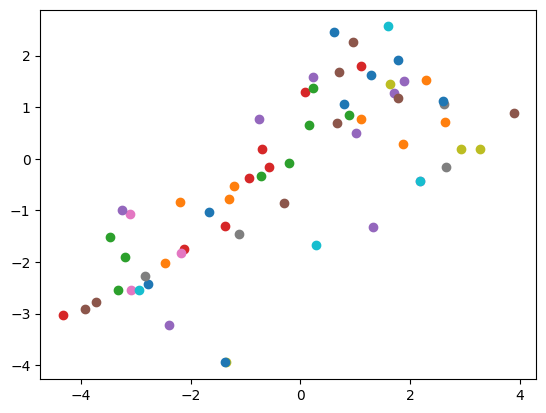

In [32]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
tsne_embeddings = tsne.fit_transform(embeddings.detach().numpy())

for i, player_id in enumerate(np.unique(labels)):
    indices = np.where(labels == player_id)[0]
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1])
plt.show()